In [1]:
from ensurepip import bootstrap
from os import cpu_count
from src.nn_support import MyNeuralNetwork, LitNeuralNetwork, MyDataset

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from collections import OrderedDict
from abc import ABC, abstractmethod
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch.nn.functional as F
from pytorch_lightning.loggers import CSVLogger


In [2]:
from src.models import NeuralNetworkModel
from src.datamodules import NeuralNetworkData

In [3]:
from src.nn_support import MyDataset

In [4]:
data_params = {
    "name": "_1_",
    "path": "data/diabetes.csv",
    "target": "Outcome",
    "cv_splits": 5,
    "cv_repeats": 1,
    "test_size": .2,
    "seed": 42,
}

# data_params = {
#     "name": "_2_",
#     "path": "data/diabetes_012_health_indicators_BRFSS2015.csv",
#     "target": "Diabetes_012",
#     "cv_splits": 5,
#     "cv_repeats": 1,
#     "test_size": .2,
#     "seed": 42,
# }

datamodule = NeuralNetworkData(**data_params)

In [5]:
model_params = {
    "layers": 2,
    "nodes": 100, 
    "dropout_rate": 0.25,
    "validation_size": 0.2,
    "seed": 42,
    "lr": 0.001,
    "patience": 1,
    "batch_size": 10
}
my_model = NeuralNetworkModel(**model_params)

In [6]:
train_generator, _ = datamodule.make_loader()
(x_data, y_data), (_, _) = next(train_generator)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(
    x_data,
    y_data,
    test_size=my_model.val, 
    stratify=y_data, 
    random_state=my_model.seed
    )

In [8]:
# Create data loaders
train_loader = DataLoader(
    MyDataset(x_train, y_train), 
    batch_size=my_model.batch_size, 
    drop_last=True, 
    num_workers=5,
    multiprocessing_context='fork'
    )
valid_loader = DataLoader(
    MyDataset(x_val, y_val), 
    batch_size=my_model.batch_size, 
    drop_last=True, 
    num_workers=5,
    multiprocessing_context='fork')

In [9]:
my_model.set_input_size(x_train.shape[1])

In [10]:
my_model.load()

In [11]:
# model
model = LitNeuralNetwork(my_model.model, my_model.lr)

In [12]:
logger = CSVLogger("example_save", name="my_exp_name")

In [13]:
# train model
trainer = pl.Trainer(
    enable_checkpointing=False,
    log_every_n_steps=5,
    deterministic=True, 
    callbacks=[my_model.early_stop_callback], 
    enable_progress_bar=False,
    logger=logger,
    )

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/chrisfarr/miniconda3/envs/gatech/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [14]:
# import logging
# logging.getLogger("lightning").setLevel(logging.ERROR)
trainer.fit(
    model=model, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader)


/Users/chrisfarr/miniconda3/envs/gatech/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name  | Type            | Params
------------------------------------------
0 | model | MyNeuralNetwork | 11.5 K
1 | loss  | BCELoss         | 0     
------------------------------------------
11.5 K    Trainable params
0         Non-trainable params
11.5 K    Total params
0.046     Total estimated model params size (MB)
/Users/chrisfarr/miniconda3/envs/gatech/lib/python3.9/site-packages/pytorch_lightning/core/module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop 

In [15]:
import pandas as pd
import numpy as np

In [16]:
log_data = pd.read_csv("example_save/my_exp_name/version_6/metrics.csv")

In [18]:
log_summary = log_data[["val_loss_epoch", "train_loss_epoch", "epoch"]].rename(
    {
        "val_loss_epoch": "val_loss",
        "train_loss_epoch": "train_loss"
        }, axis=1
    ).groupby("epoch").mean()

In [19]:
list(log_summary.index)

[0.0, 1.0, 2.0, 3.0]

In [21]:
y_axis = log_summary.to_dict(orient="records")

In [23]:
y_axis

[{'val_loss': 0.538408637046814, 'train_loss': 0.5761696696281433},
 {'val_loss': 0.4956627190113067, 'train_loss': 0.4611466228961944},
 {'val_loss': 0.4806368947029114, 'train_loss': 0.4316616654396057},
 {'val_loss': 0.4924139380455017, 'train_loss': 0.4041965305805206}]

In [22]:
np.array([v for d in y_axis for k, v in d.items() if "test" in k])

array([], dtype=float64)

In [34]:
log_data.head()



,valid,step,train,train_loss_step,epoch,val_loss_step,val_loss_epoch,train_loss_epoch
0,0.756214,0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.752912,1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2,0.842993,NaN,NaN,NaN,NaN,NaN
3,NaN,3,0.848120,NaN,NaN,NaN,NaN,NaN
4,NaN,4,0.836313,NaN,NaN,NaN,NaN,NaN


In [36]:
log_data.groupby("epoch")[["val_loss_epoch", "train_loss_epoch"]].mean()


,val_loss_epoch,train_loss_epoch
epoch,,
0.0,0.347459,0.362108
1.0,0.344278,0.347355
2.0,0.342507,0.344118
3.0,0.342325,0.342961
4.0,0.341531,0.341830
5.0,0.340694,0.341755
6.0,0.340634,0.340788
7.0,0.340422,0.340556
8.0,0.340349,0.340201


<AxesSubplot:xlabel='epoch'>

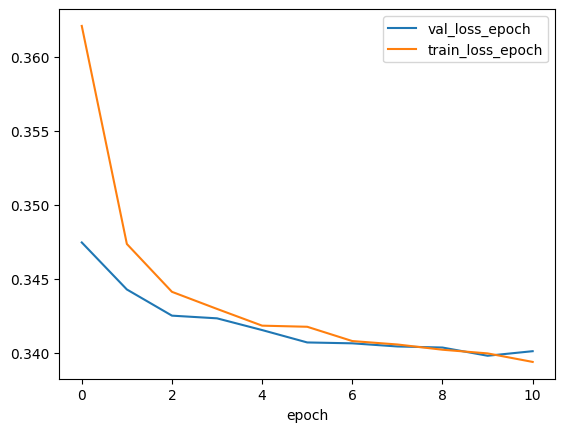

In [35]:
log_data.groupby("epoch")[["val_loss_epoch", "train_loss_epoch"]].mean().plot()